### Calculate Geostrophic Velocity based on Shear and ADCP Reference Velocity at 600m ###

In [35]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import gsw
import xarray as xr
from matplotlib import cm

mpl.rcParams.update({
    'font.size': 14,           # Default font size
    'axes.labelsize': 14,      # Font size for axis labels
    'axes.titlesize': 16,      # Font size for titles
    'xtick.labelsize': 12,     # Font size for x-axis ticks
    'ytick.labelsize': 12,     # Font size for y-axis ticks
    'legend.fontsize': 12,     # Font size for legend
    'figure.titlesize': 18     # Font size for figure titles
})

In [2]:
datadir = './CTD/'

allCTDs = ["TN4270301d.cnv", "TN4270401d.cnv", "TN4270501d.cnv", "TN4270601d.cnv", "TN4270701d.cnv",
            "TN4270801d.cnv", "TN4270901d.cnv", "TN4271001d.cnv", 
           "TN4271101d.cnv", "TN4271201d.cnv", "TN4271301d.cnv", "TN4271401d.cnv",
          "TN4271502d.cnv"]

latitudes = {
    "TN4270301d.cnv": [-5],
    "TN4270401d.cnv": [-4],
    "TN4270501d.cnv": [-3],
    "TN4270601d.cnv": [-2],
    "TN4270701d.cnv": [-1],
    "TN4270801d.cnv": [-0.5],
    "TN4270901d.cnv": [0],
    "TN4271001d.cnv": [0.5],
    "TN4271101d.cnv": [1],
    "TN4271201d.cnv": [2],
    "TN4271301d.cnv": [3],
    "TN4271401d.cnv": [4],
    "TN4271502d.cnv": [5]
}

new_lats = {
    "TN4270401d.cnv": [-4.5],
    "TN4270501d.cnv": [-3.5],
    "TN4270601d.cnv": [-2.5],
    "TN4270701d.cnv": [-1.5],
    "TN4270801d.cnv": [-0.8],
    "TN4270901d.cnv": [-0.3],
    "TN4271001d.cnv": [0.2],
    "TN4271101d.cnv": [0.7],
    "TN4271201d.cnv": [1.5],
    "TN4271301d.cnv": [2.5],
    "TN4271401d.cnv": [3.5],
    "TN4271502d.cnv": [4.5]
}

### Calculate DELTA Dynamic Height over DELTA Distance ###

In [3]:
shear = {}
pressure = {}
latitude = {}

for i in range(1, len(allCTDs)):
    CTD_current = datadir + allCTDs[i]
    CTD_previous = datadir + allCTDs[i - 1]

    P_current, AS_current, CT_current = np.genfromtxt(fname=CTD_current, usecols=(2, 20, 22), skip_header=387, unpack=True, encoding='iso-8859-1')
    P_previous, AS_previous, CT_previous = np.genfromtxt(fname=CTD_previous, usecols=(2, 20, 22), skip_header=387, unpack=True, encoding='iso-8859-1')

    #if the files have different lengths, take the smaller one so the difference can be found.
    min_length = min(len(P_current), len(P_previous))

    #find deltDH for both stations with the smallest length
    currentDH = gsw.geo_strf_dyn_height(AS_current[:min_length], CT_current[:min_length], P_current[:min_length], 700)
    previousDH = gsw.geo_strf_dyn_height(AS_previous[:min_length], CT_previous[:min_length], P_previous[:min_length], 700)

    deltDH = currentDH - previousDH

    currentLat = latitudes[allCTDs[i]][0]
    previousLat = latitudes[allCTDs[i - 1]][0]

    deltLat = abs(currentLat) - abs(previousLat)
    
    deltLatkm = abs(deltLat) * 111000
    
    if currentLat == 0.5:
        current_lat = 0.25
    elif currentLat == -0.5:
        current_lat = -0.75
    elif currentLat == 0:
        current_lat = -0.25
    elif currentLat == 1:
        current_lat = 0.75
    else:
        current_lat = currentLat - 0.5
    #print(f"i: {i}, CTD: {allCTDs[i]}, Current Lat: {currentLat}, Previous Lat: {previousLat}, Delta Lat: {deltLat}")

    shearCalc = deltDH / deltLatkm

    #append
    shear[allCTDs[i]] = shearCalc
    pressure[allCTDs[i]] = P_current[:min_length]
    latitude[allCTDs[i]] = [current_lat]


### Find ADCP Reference Velocity at 600m ###

In [4]:
filepathadcp = '2024_os75nb_cleaned.nc'
ADCP_all = xr.open_dataset(filepathadcp, decode_times=False)

ADCP_df = ADCP_all.to_dataframe()
ADCP_df['rounded_lat'] = ADCP_df['lat'].round(1).astype(float)


In [14]:
specified_latitudes = [-4.50, -3.50, -2.50, -1.50, -0.75, -0.25, 0.25, 0.75, 1.50, 2.50, 3.50, 4.50]

# round latitudes to 1 decimal place
ADCP_df['rounded_lat'] = ADCP_df['lat'].round(1)

u600 = []

for lat in specified_latitudes:
    # Find the nearest latitude in the ADCP DataFrame
    nearest_lat = ADCP_df['rounded_lat'].values[(np.abs(ADCP_df['rounded_lat'] - lat)).argmin()]
    
    # Filter ADCP data for the nearest latitude
    current_lat_data = ADCP_df[ADCP_df['rounded_lat'] == nearest_lat]
    
    # Find the depth closest to 600 meters
    closest_depth_idx = np.argmin(np.abs(current_lat_data['z'] - 600))
    
    # Check if there is valid data at 600 meters
    if not np.isnan(current_lat_data['u'].values).all():
        # Save u velocity at the closest depth to 600 meters with the corresponding latitude
        u600.append({'latitude': nearest_lat, 'u600': current_lat_data['u'].values[closest_depth_idx]})
        
# Print the list of dictionaries containing latitude and u velocity at the closest depth to 600 meters
#print("u velocities at the closest depth to 600 meters:")
#print(u600)

In [7]:
u600_new=np.zeros(len(u600))
lats_new=np.zeros(len(u600))
for i in range(len(u600)):
 u600_new[i]=u600[i]['u600']
 lats_new[i]=u600[i]['latitude']

### Calculate and Plot Geostrophic Velocity against ADCP Averaged and Rounded Velocity ###

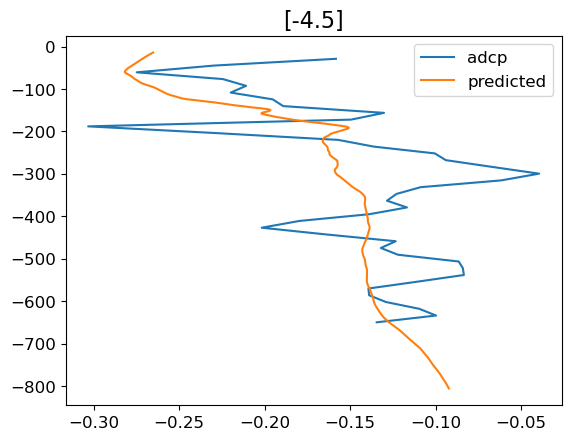

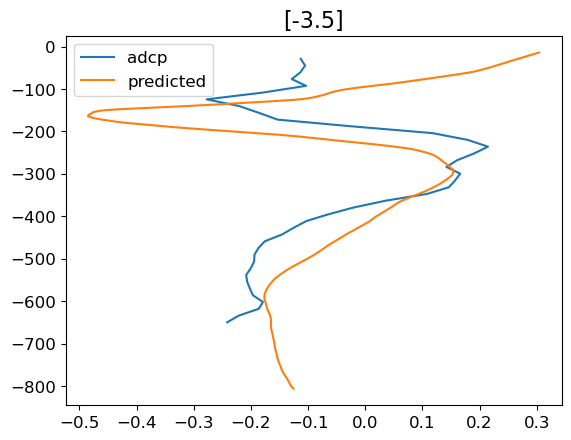

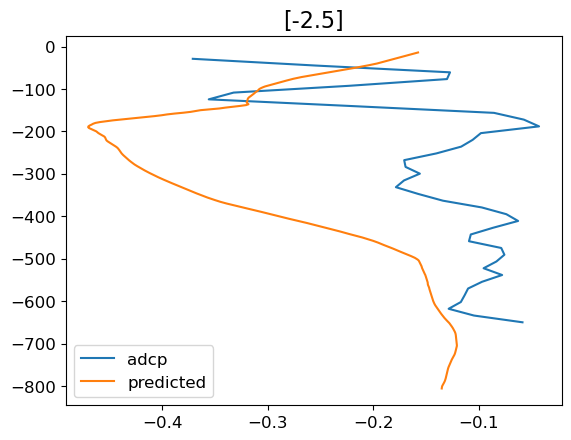

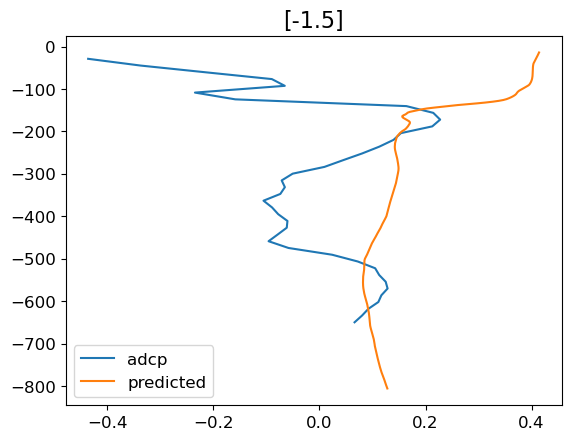

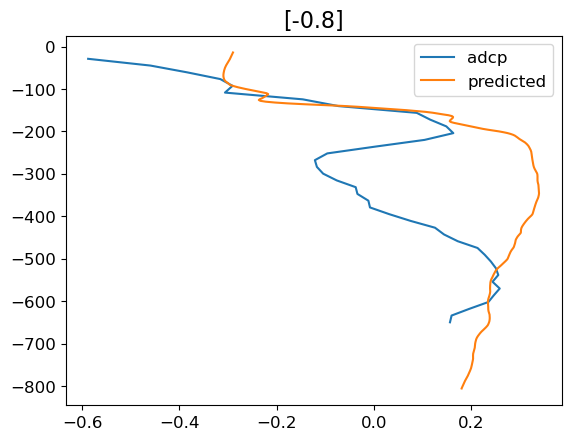

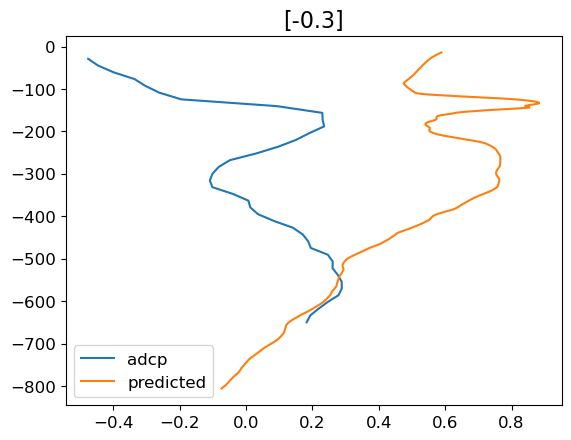

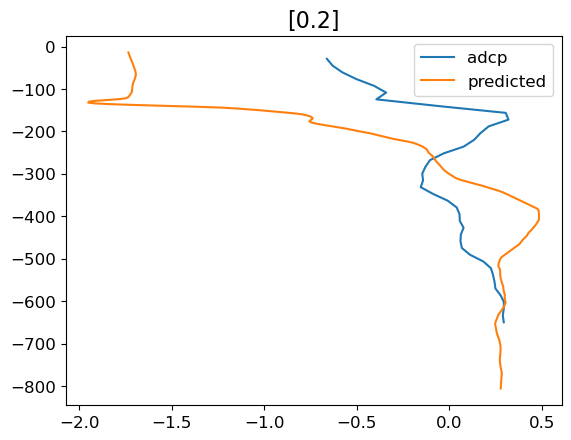

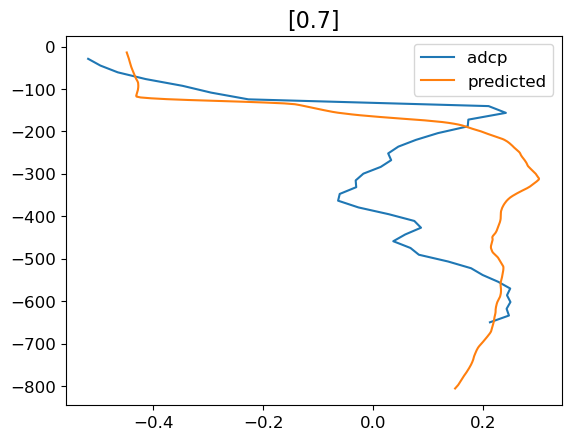

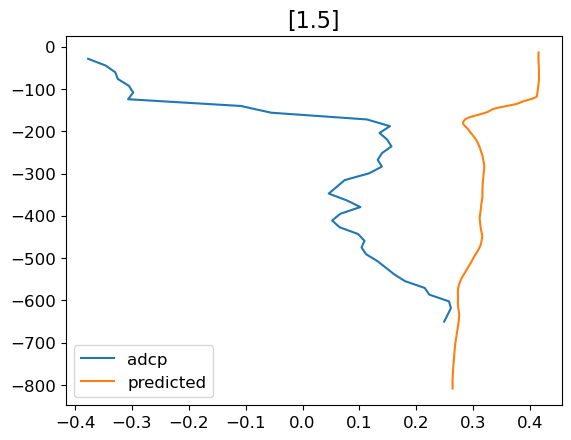

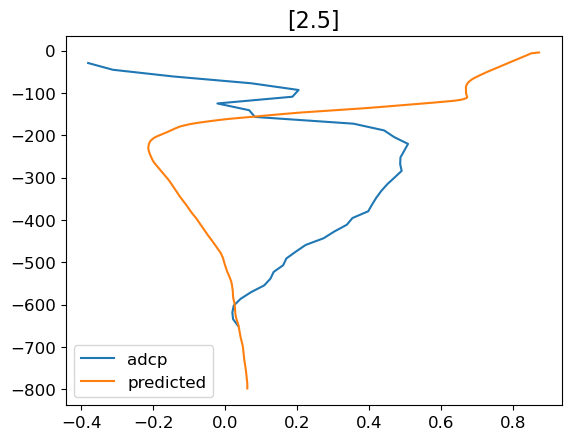

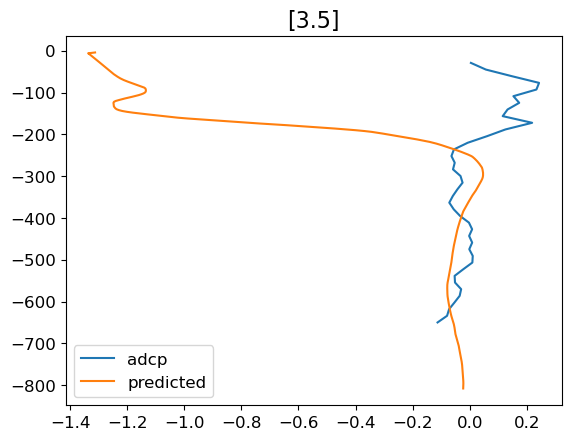

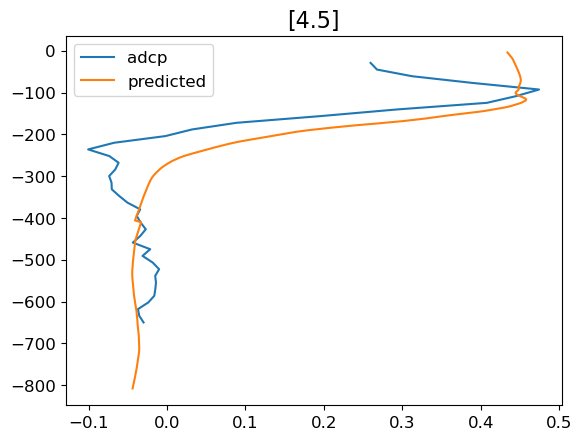

In [13]:
for current_file in allCTDs[1:]:
    
    lat = new_lats[current_file][0]

    # gravity and coriolis
    g = 9.81
    f = 2 * 0.000072921 * math.sin(lat)

    u_predicted=(shear[current_file]-shear[current_file][pressure[current_file]==600])*g/f + u600_new[lats_new==lat]

    u=ADCP_df[ADCP_df['rounded_lat']==lat]['u']
    z=ADCP_df[ADCP_df['rounded_lat']==lat]['z']
    u_avg=np.zeros(len(z.unique()))
    z_unique=z.unique()
    for i in range(len(u_avg)):
        u_avg[i]=np.mean(u[z==z.unique()[i]])
    plt.figure()    
    plt.plot(u_avg,-z_unique,label='adcp')
    plt.plot(u_predicted,-pressure[current_file],label='predicted')
    plt.title(str(new_lats[current_file]))
    plt.legend()

### Plot Individual Profiles of Predicted VS ADCP ###

TN4271502d.cnv


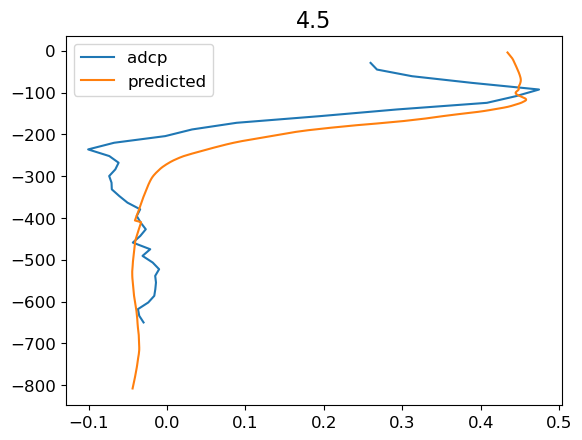

In [148]:
current_file=allCTDs[12]

lat = new_lats[current_file][0]

# gravity and coriolis
g = 9.81
f = 2 * 0.000072921 * math.sin(lat)

u_predicted=(shear[current_file]-shear[current_file][pressure[current_file]==600])*g/f + u600_new[lats_new==lat]

u=ADCP_df[ADCP_df['rounded_lat']==lat]['u']
z=ADCP_df[ADCP_df['rounded_lat']==lat]['z']
u_avg=np.zeros(len(z.unique()))
z_unique=z.unique()

for i in range(len(u_avg)):
    u_avg[i]=np.mean(u[z==z.unique()[i]])
    
plt.plot(u_avg,-z_unique,label='adcp')
plt.plot(u_predicted,-pressure[current_file],label='predicted')
plt.title(str(lat))
plt.legend()
print(current_file)

### Plot all Predicted Velocities ###

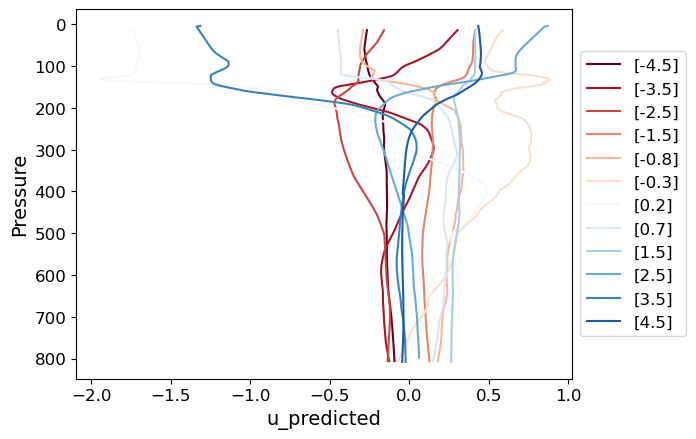

In [33]:
for i, current_file in enumerate(allCTDs[1:]):
     
    color = plt.cm.RdBu(i / len(allCTDs[1:]))
    
    lat = new_lats[current_file][0]

    # gravity and coriolis
    g = 9.81
    f = 2 * 0.000072921 * math.sin(lat)
    
    u_predicted=(shear[current_file]-shear[current_file][pressure[current_file]==600])*g/f + u600_new[lats_new==lat]
    
    plt.plot(u_predicted, pressure[current_file], label=new_lats[current_file], color=color)
    
plt.gca().invert_yaxis()
plt.xlabel('u_predicted')
plt.ylabel('Pressure')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


### Plot all ADCP Velocities ###

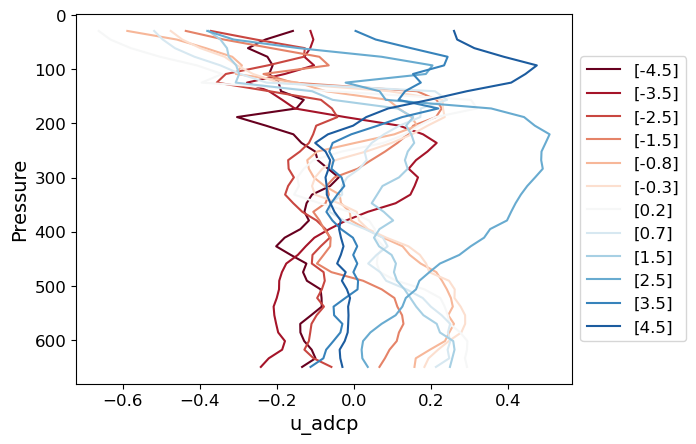

In [34]:
for i, current_file in enumerate(allCTDs[1:]):
     
    color = plt.cm.RdBu(i / len(allCTDs[1:]))
    
    lat = new_lats[current_file][0]

    u=ADCP_df[ADCP_df['rounded_lat']==lat]['u']
    z=ADCP_df[ADCP_df['rounded_lat']==lat]['z']
    u_avg=np.zeros(len(z.unique()))
    z_unique=z.unique()
    for i in range(len(u_avg)):
        u_avg[i]=np.mean(u[z==z.unique()[i]])
    
    plt.plot(u_avg,z_unique,label=new_lats[current_file], color=color)
    
plt.gca().invert_yaxis()
plt.xlabel('u_adcp')
plt.ylabel('Pressure')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


### Calculate Error of Predicted VS ADCP ###

In [142]:
u_filter = {}
filtered_pressure = {}

for key, value in pressure.items():
    matching_values = [val for val in value if any(np.isclose(val, target) for target in z_unique_rounded)]
    if matching_values:
        filtered_pressure[key] = matching_values


for key in filtered_pressure.keys():
    lat = new_lats[key][0]
    g = 9.81
    f = 2 * 0.000072921 * math.sin(lat)
    u_predicted = (shear[key] - shear[key][pressure[key] == 600]) * g / f + u600_new[lats_new == lat]


    closest_indices = np.abs(pressure[key] - np.array(filtered_pressure[key])[:, np.newaxis]).argmin(axis=1)
    u = u_predicted[closest_indices]

    u_filter[key] = u

In [151]:
error = {}
absError = {}
relativeError = {}
percentError = {}
meanAbsError = {}
meanSquareError = {}
RMSError = {}

for index, current_file in enumerate(allCTDs[1:]):
    lat = new_lats[current_file][0]
    g = 9.81
    f = 2 * 0.000072921 * math.sin(lat)

    u_predicted=(shear[current_file]-shear[current_file][pressure[current_file]==600])*g/f + u600_new[lats_new==lat]

    u=ADCP_df[ADCP_df['rounded_lat']==lat]['u']
    z=ADCP_df[ADCP_df['rounded_lat']==lat]['z']
    u_avg=np.zeros(len(z.unique()))
    z_unique=z.unique()
    
    
    for i in range(len(u_avg)):
        u_avg[i]=np.mean(u[z==z.unique()[i]])
        
    z_unique_rounded = ((z_unique/2).round(0))*2
    
    z_pred = [pressure==z_unique_rounded]
        
    # error    
    er = u_avg - u_filter[current_file]
    error[current_file] = np.mean(er).round(3)
    
    # absolute error
    absolute = np.abs(er)
    absError[current_file] = np.mean(absolute).round(3)
    
    # relative error
    relative = absolute/u_avg
    relativeError[current_file] = np.mean(relative).round(3)
    
    # percentage error
    percent = relative*100
    percentError[current_file] = np.mean(percent).round(3)
    
    # mean absolute error
    mean = np.mean(absolute)
    meanAbsError[current_file] = mean.round(3)
    
    # mean square error
    ms = np.mean((er)**2)
    meanSquareError[current_file] = ms.round(3)
    
    # root mean square error
    rms = np.sqrt(ms)
    RMSError[current_file] = rms.round(3)

### Print Errors ###

In [154]:
# -4.5
key = 'TN4270401d.cnv'

print(f"{key}; latitude: {new_lats[key][0]} ")
print(f"error: {error.get(key)}")
print(f"absolute error: {absError.get(key)}")
print(f"relative error: {relativeError.get(key)}")
print(f"percent error: {percentError.get(key)}")
print(f"mean absolute error: {meanAbsError.get(key)}")
print(f"mean square error: {meanSquareError.get(key)}")
print(f"root mean square error: {RMSError.get(key)}")
print()
print()

# -3.5
key = 'TN4270501d.cnv'

print(f"{key}; latitude: {new_lats[key][0]} ")
print(f"error: {error.get(key)}")
print(f"absolute error: {absError.get(key)}")
print(f"relative error: {relativeError.get(key)}")
print(f"percent error: {percentError.get(key)}")
print(f"mean absolute error: {meanAbsError.get(key)}")
print(f"mean square error: {meanSquareError.get(key)}")
print(f"root mean square error: {RMSError.get(key)}")
print()
print()

# -2.5
key = 'TN4270601d.cnv'

print(f"{key}; latitude: {new_lats[key][0]} ")
print(f"error: {error.get(key)}")
print(f"absolute error: {absError.get(key)}")
print(f"relative error: {relativeError.get(key)}")
print(f"percent error: {percentError.get(key)}")
print(f"mean absolute error: {meanAbsError.get(key)}")
print(f"mean square error: {meanSquareError.get(key)}")
print(f"root mean square error: {RMSError.get(key)}")
print()
print()

# -1.5
key = 'TN4270701d.cnv'

print(f"{key}; latitude: {new_lats[key][0]} ")
print(f"error: {error.get(key)}")
print(f"absolute error: {absError.get(key)}")
print(f"relative error: {relativeError.get(key)}")
print(f"percent error: {percentError.get(key)}")
print(f"mean absolute error: {meanAbsError.get(key)}")
print(f"mean square error: {meanSquareError.get(key)}")
print(f"root mean square error: {RMSError.get(key)}")
print()
print()

# -0.75
key = 'TN4270801d.cnv'

print(f"{key}; latitude: {new_lats[key][0]} ")
print(f"error: {error.get(key)}")
print(f"absolute error: {absError.get(key)}")
print(f"relative error: {relativeError.get(key)}")
print(f"percent error: {percentError.get(key)}")
print(f"mean absolute error: {meanAbsError.get(key)}")
print(f"mean square error: {meanSquareError.get(key)}")
print(f"root mean square error: {RMSError.get(key)}")
print()
print()

# -0.25
key = 'TN4270901d.cnv'

print(f"{key}; latitude: {new_lats[key][0]} ")
print(f"error: {error.get(key)}")
print(f"absolute error: {absError.get(key)}")
print(f"relative error: {relativeError.get(key)}")
print(f"percent error: {percentError.get(key)}")
print(f"mean absolute error: {meanAbsError.get(key)}")
print(f"mean square error: {meanSquareError.get(key)}")
print(f"root mean square error: {RMSError.get(key)}")
print()
print()

# 0.25
key = 'TN4271001d.cnv'

print(f"{key}; latitude: {new_lats[key][0]} ")
print(f"error: {error.get(key)}")
print(f"absolute error: {absError.get(key)}")
print(f"relative error: {relativeError.get(key)}")
print(f"percent error: {percentError.get(key)}")
print(f"mean absolute error: {meanAbsError.get(key)}")
print(f"mean square error: {meanSquareError.get(key)}")
print(f"root mean square error: {RMSError.get(key)}")
print()
print()

# 0.7
key = 'TN4271101d.cnv'

print(f"{key}; latitude: {new_lats[key][0]} ")
print(f"error: {error.get(key)}")
print(f"absolute error: {absError.get(key)}")
print(f"relative error: {relativeError.get(key)}")
print(f"percent error: {percentError.get(key)}")
print(f"mean absolute error: {meanAbsError.get(key)}")
print(f"mean square error: {meanSquareError.get(key)}")
print(f"root mean square error: {RMSError.get(key)}")
print()
print()

# 1.5
key = 'TN4271201d.cnv'

print(f"{key}; latitude: {new_lats[key][0]} ")
print(f"error: {error.get(key)}")
print(f"absolute error: {absError.get(key)}")
print(f"relative error: {relativeError.get(key)}")
print(f"percent error: {percentError.get(key)}")
print(f"mean absolute error: {meanAbsError.get(key)}")
print(f"mean square error: {meanSquareError.get(key)}")
print(f"root mean square error: {RMSError.get(key)}")
print()
print()

# 2.5
key = 'TN4271301d.cnv'

print(f"{key}; latitude: {new_lats[key][0]} ")
print(f"error: {error.get(key)}")
print(f"absolute error: {absError.get(key)}")
print(f"relative error: {relativeError.get(key)}")
print(f"percent error: {percentError.get(key)}")
print(f"mean absolute error: {meanAbsError.get(key)}")
print(f"mean square error: {meanSquareError.get(key)}")
print(f"root mean square error: {RMSError.get(key)}")
print()
print()

# 2.5
key = 'TN4271301d.cnv'

print(f"{key}; latitude: {new_lats[key][0]} ")
print(f"error: {error.get(key)}")
print(f"absolute error: {absError.get(key)}")
print(f"relative error: {relativeError.get(key)}")
print(f"percent error: {percentError.get(key)}")
print(f"mean absolute error: {meanAbsError.get(key)}")
print(f"mean square error: {meanSquareError.get(key)}")
print(f"root mean square error: {RMSError.get(key)}")
print()
print()

# 3.5
key = 'TN4271401d.cnv'

print(f"{key}; latitude: {new_lats[key][0]} ")
print(f"error: {error.get(key)}")
print(f"absolute error: {absError.get(key)}")
print(f"relative error: {relativeError.get(key)}")
print(f"percent error: {percentError.get(key)}")
print(f"mean absolute error: {meanAbsError.get(key)}")
print(f"mean square error: {meanSquareError.get(key)}")
print(f"root mean square error: {RMSError.get(key)}")
print()
print()

# 4.5
key = 'TN4271502d.cnv'

print(f"{key}; latitude: {new_lats[key][0]} ")
print(f"error: {error.get(key)}")
print(f"absolute error: {absError.get(key)}")
print(f"relative error: {relativeError.get(key)}")
print(f"percent error: {percentError.get(key)}")
print(f"mean absolute error: {meanAbsError.get(key)}")
print(f"mean square error: {meanSquareError.get(key)}")
print(f"root mean square error: {RMSError.get(key)}")
print()
print()

TN4270401d.cnv; latitude: -4.5 
error: 0.025
absolute error: 0.043
relative error: -0.395
percent error: -39.526
mean absolute error: 0.043
mean square error: 0.003
root mean square error: 0.055


TN4270501d.cnv; latitude: -3.5 
error: -0.027
absolute error: 0.122
relative error: -0.92
percent error: -92.019
mean absolute error: 0.122
mean square error: 0.027
root mean square error: 0.163


TN4270601d.cnv; latitude: -2.5 
error: 0.147
absolute error: 0.162
relative error: -1.651
percent error: -165.149
mean absolute error: 0.162
mean square error: 0.039
root mean square error: 0.198


TN4270701d.cnv; latitude: -1.5 
error: -0.171
absolute error: 0.189
relative error: -0.848
percent error: -84.757
mean absolute error: 0.189
mean square error: 0.082
root mean square error: 0.286


TN4270801d.cnv; latitude: -0.8 
error: -0.155
absolute error: 0.161
relative error: 0.356
percent error: 35.574
mean absolute error: 0.161
mean square error: 0.05
root mean square error: 0.223


TN4270901d.cnv;

### Actual vs Predicted Scatter with Regression ###

Text(0, 0.5, 'Predicted Velocities')

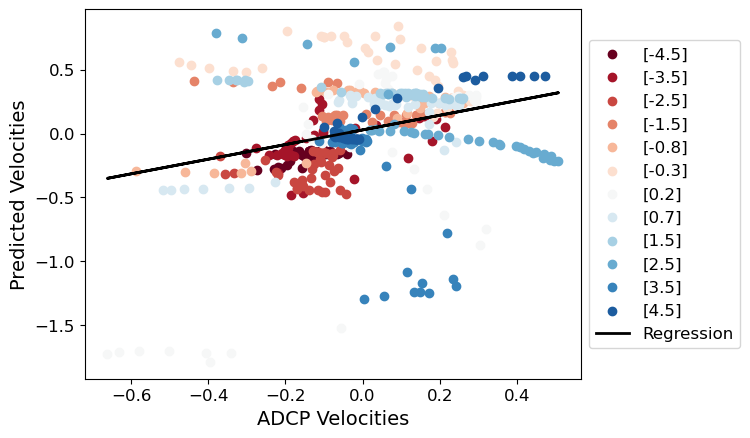

In [172]:
all_u_avg = []
all_u_filter = []

for i, current_file in enumerate(allCTDs[1:]):
    lat = new_lats[current_file][0]

    # gravity and coriolis
    g = 9.81
    f = 2 * 0.000072921 * math.sin(lat)

    u_predicted = (shear[current_file] - shear[current_file][pressure[current_file] == 600]) * g / f + u600_new[lats_new == lat]

    u = ADCP_df[ADCP_df['rounded_lat'] == lat]['u']
    z = ADCP_df[ADCP_df['rounded_lat'] == lat]['z']
    u_avg = np.zeros(len(z.unique()))
    z_unique = z.unique()
    for i in range(len(u_avg)):
        u_avg[i] = np.mean(u[z == z_unique[i]])

    all_u_avg.extend(u_avg)
    all_u_filter.extend(u_filter[current_file])

# Linear regression for all cumulative points
coeffs = np.polyfit(all_u_avg, all_u_filter, 1)
poly = np.poly1d(coeffs)

for i, current_file in enumerate(allCTDs[1:]):
     
    color = plt.cm.RdBu(i / len(allCTDs[1:]))
    
    lat = new_lats[current_file][0]

    # gravity and coriolis
    g = 9.81
    f = 2 * 0.000072921 * math.sin(lat)

    u_predicted=(shear[current_file]-shear[current_file][pressure[current_file]==600])*g/f + u600_new[lats_new==lat]

    u=ADCP_df[ADCP_df['rounded_lat']==lat]['u']
    z=ADCP_df[ADCP_df['rounded_lat']==lat]['z']
    u_avg=np.zeros(len(z.unique()))
    z_unique=z.unique()
    for i in range(len(u_avg)):
        u_avg[i]=np.mean(u[z==z.unique()[i]])
    plt.scatter(u_avg,u_filter[current_file],label=new_lats[current_file], color=color)
    
# Regression line
plt.plot(all_u_avg, poly(all_u_avg), color='black', lw=2, label='Regression')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('ADCP Velocities')
plt.ylabel('Predicted Velocities')

### All Regressions ###

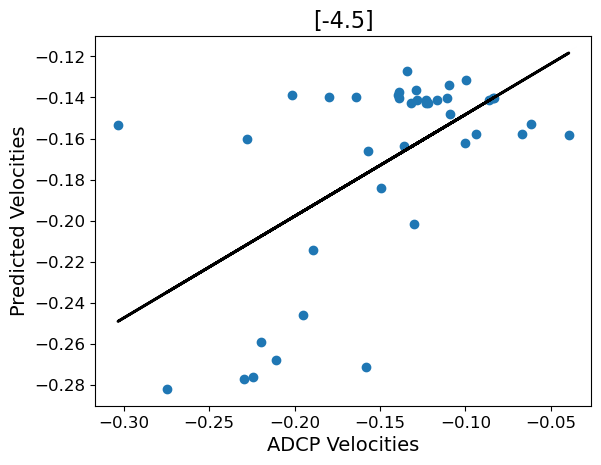

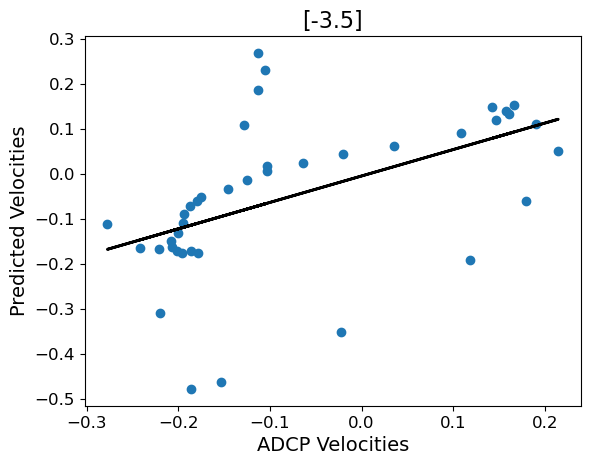

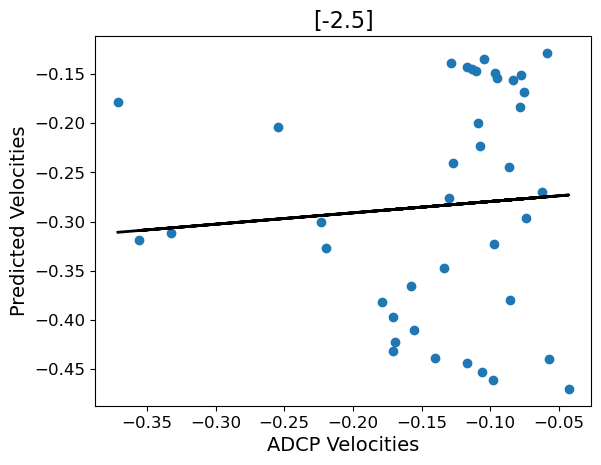

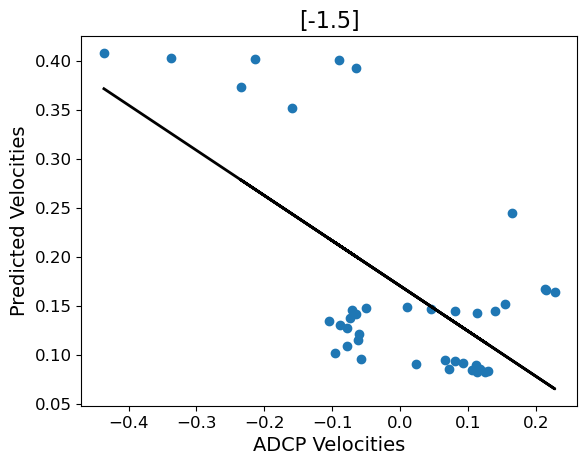

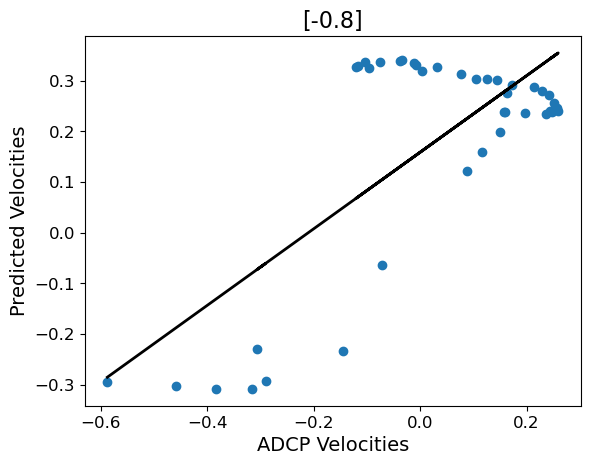

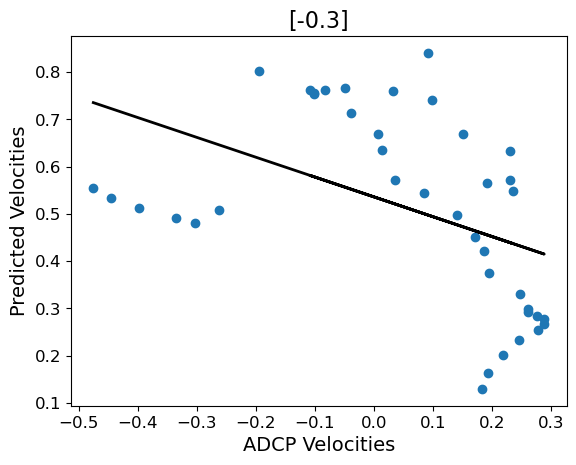

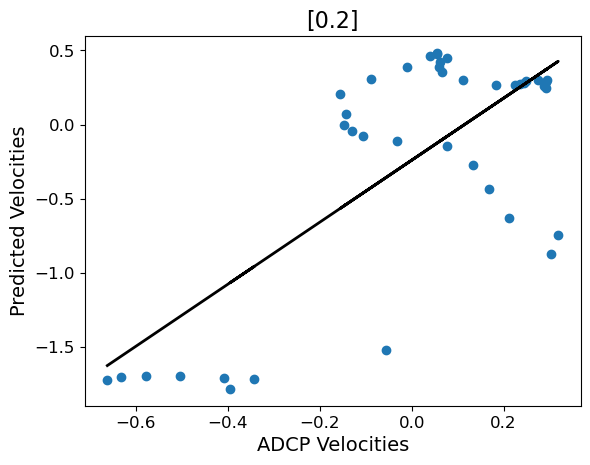

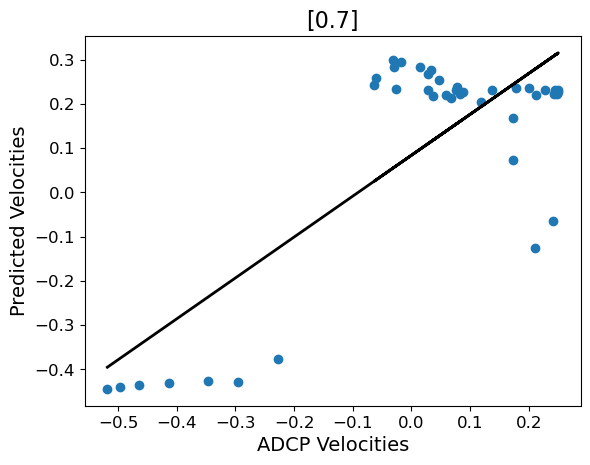

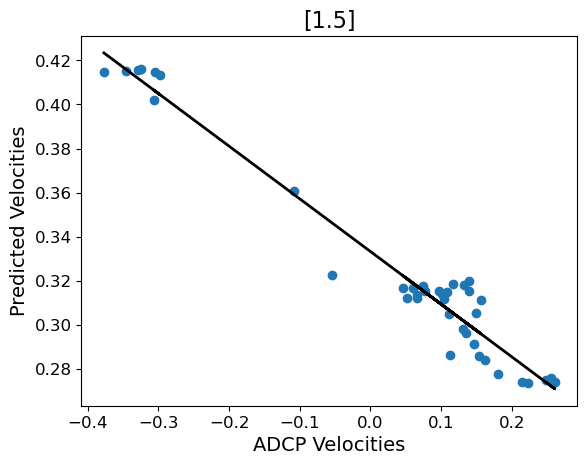

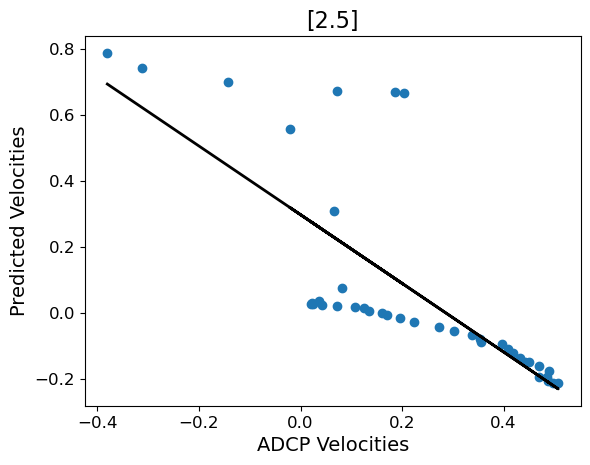

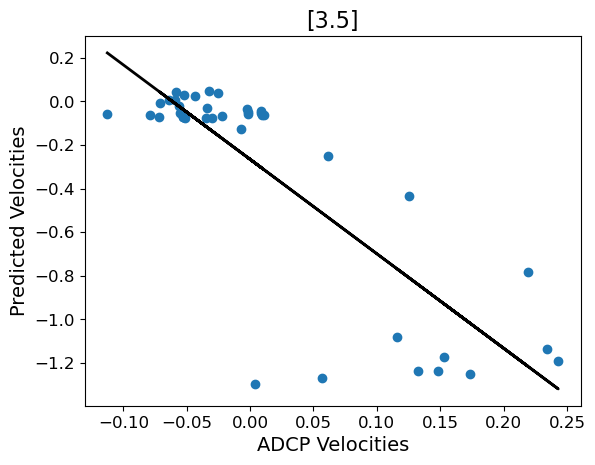

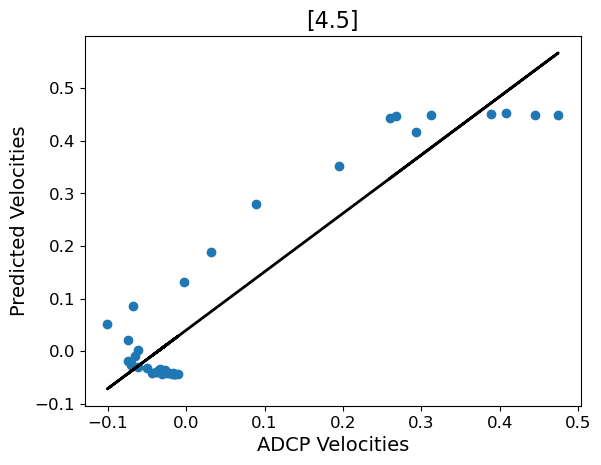

In [178]:
# Create a single figure outside the loop
for current_file in allCTDs[1:]:
    lat = new_lats[current_file][0]

    # gravity and coriolis
    g = 9.81
    f = 2 * 0.000072921 * math.sin(lat)

    u_predicted = (shear[current_file] - shear[current_file][pressure[current_file] == 600]) * g / f + u600_new[lats_new == lat]

    u = ADCP_df[ADCP_df['rounded_lat'] == lat]['u']
    z = ADCP_df[ADCP_df['rounded_lat'] == lat]['z']
    u_avg = np.zeros(len(z.unique()))
    z_unique = z.unique()
    for i in range(len(u_avg)):
        u_avg[i] = np.mean(u[z == z_unique[i]])
    plt.figure()
    # Scatter plot
    plt.scatter(u_avg, u_filter[current_file], label=new_lats[current_file])

    # Linear regression
    coeffs = np.polyfit(u_avg, u_filter[current_file], 1)
    poly = np.poly1d(coeffs)

    # Plot the regression line on the same figure
    plt.plot(u_avg, poly(u_avg), color='black', lw=2, label='Regression Line')
    plt.title(str(new_lats[current_file]))
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('ADCP Velocities')
    plt.ylabel('Predicted Velocities')



### Individual Regressions ###

Text(0, 0.5, 'Predicted Velocities')

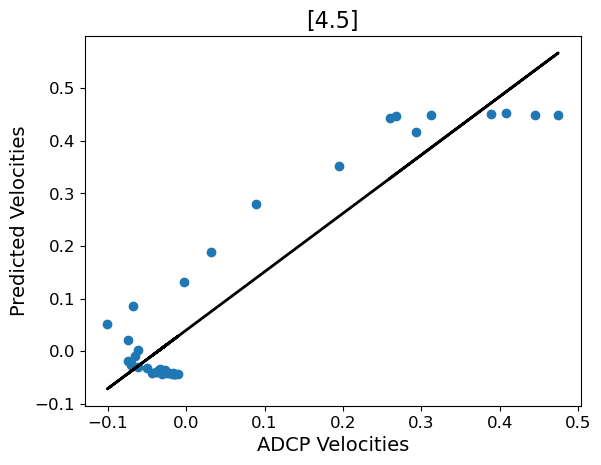

In [180]:
current_file=allCTDs[12]

lat = new_lats[current_file][0]

# gravity and coriolis
g = 9.81
f = 2 * 0.000072921 * math.sin(lat)

u_predicted = (shear[current_file] - shear[current_file][pressure[current_file] == 600]) * g / f + u600_new[lats_new == lat]

u = ADCP_df[ADCP_df['rounded_lat'] == lat]['u']
z = ADCP_df[ADCP_df['rounded_lat'] == lat]['z']
u_avg = np.zeros(len(z.unique()))
z_unique = z.unique()
for i in range(len(u_avg)):
    u_avg[i] = np.mean(u[z == z_unique[i]])
plt.figure()
# Scatter plot
plt.scatter(u_avg, u_filter[current_file], label=new_lats[current_file])

# Linear regression
coeffs = np.polyfit(u_avg, u_filter[current_file], 1)
poly = np.poly1d(coeffs)

# Plot the regression line on the same figure
plt.plot(u_avg, poly(u_avg), color='black', lw=2, label='Regression Line')
plt.title(str(new_lats[current_file]))
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('ADCP Velocities')
plt.ylabel('Predicted Velocities')